**Посчитать утилизацию (мин в день) , при которой клиент с большей вероятностью продлит и не продлит подписку**

In [587]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
import gspread

# Импортируем библиотеку tqdm для отображения прогресс бара
from tqdm import tqdm

# sns.set_style('whitegrid')

In [588]:
# Выргужаю данные об уроках
lessons = pd.read_csv('/Users/v.obrosova/DE/data_csv/pay.csv', low_memory=False)
lessons = lessons.loc[:,~lessons.columns.str.contains('^Unnamed')]
lessons= lessons[['Start_Time','Duration [min]','Student\'s email']]
lessons = lessons.rename(columns={'Duration [min]':'duration',
                                  'Student\'s email':'email',
                                  'Start_Time':'date_lessons'})

lessons['date_lessons'] = pd.to_datetime(lessons['date_lessons'])
lessons.dropna(inplace=True)
lessons.replace([np.inf, -np.inf], np.nan, inplace=True)

lessons['duration'] = lessons['duration'].astype(int)

lessons = lessons.query('duration > 28 & duration < 130')

lessons.head()

,date_lessons,duration,email
15,2022-01-11 13:35:32.253000+00:00,30,apple867@yandex.ru
30,2022-01-05 08:00:00+00:00,64,anjelikab@yandex.ru
31,2022-01-07 08:00:00+00:00,61,anjelikab@yandex.ru
32,2022-01-09 09:00:00+00:00,56,anjelikab@yandex.ru
35,2022-01-03 10:00:00+00:00,57,beloheica@yandex.ru


In [589]:
# Выгружаю данные об оплатах
pay = pd.read_csv('/Users/v.obrosova/Downloads/Реестр оплат-Все и сразу.csv')
pay = pay[['Дата','Email','Транзакций','Статус']]
pay = pay.dropna()

pay = pay.rename(columns={'Дата':'date',
                          'Email':'email'})

pay['Транзакций'] = pay['Транзакций'].str.replace(',','.').str.replace(' ','').astype('float').astype('int')
pay['date'] = pd.to_datetime(pay['date'], dayfirst = True)

start_date = '2022-01-01'
end_date = '2023-04-10'

pay = pay.loc[(pay['date'] >= start_date) & (pay['date'] <= end_date)]
pay.dropna(inplace=True)

pay = pay.groupby('email', as_index = False)['Транзакций'].sum()

pay.head()

,email,Транзакций
0,galka-kud@yandex.ru,5
1,kylikova1992@mail.ru,2
2,mashustik40@gmail.com,2
3,urup-mpkprofessional@inbox.ru,18
4,0036111@gmail.com,1


##### Найти утилизацию каждого клиента за весь период

In [460]:
# Утилизация каждого клиента за весь период
all_minutes_of_clients = lessons.groupby('email')['duration'].sum().reset_index().sort_values('duration', ascending=True)

# Деление утилизации на квартили
Q1 = all_minutes_of_clients['duration'].quantile(0.25)
Q3 = all_minutes_of_clients['duration'].quantile(0.75)
IQR = Q3 - Q1

all_minutes_of_clients = all_minutes_of_clients[(all_minutes_of_clients['duration'] >= Q1 - 1.5 * IQR) & (all_minutes_of_clients['duration'] <= Q3 + 1.5 * IQR)]

q1 = all_minutes_of_clients['duration'].quantile(0.25)
q2 = all_minutes_of_clients['duration'].quantile(0.5)
q3 = all_minutes_of_clients['duration'].quantile(0.75)

all_minutes_of_clients['quartile'] = pd.cut(all_minutes_of_clients['duration'], bins=[0, q1, q2, q3, np.inf],
                                                                                labels=['(30 - 333)', '(334 - 765)', '(766 - 1401)', '(1402 - 3466)'])

grouped = all_minutes_of_clients.groupby('quartile')['duration'].mean()

for quartile, group in all_minutes_of_clients.groupby('quartile')['duration']:
    print(f"{quartile}: Mean = {group.mean():.2f}, Min = {group.min():.2f}, Max = {group.max():.2f}")

(30 - 333): Mean = 165.20, Min = 30.00, Max = 333.00
(334 - 765): Mean = 542.44, Min = 334.00, Max = 765.00
(766 - 1401): Mean = 1065.22, Min = 766.00, Max = 1401.00
(1402 - 3466): Mean = 2144.08, Min = 1402.00, Max = 3466.00


##### Расчет вероятности продления/не продления подписки на основе утилизации каждого клиента за все время

In [390]:
# Клиенты продлившие подписку
subs = pay.query('Транзакций > 1').groupby('email').agg({'Транзакций':'sum'}).reset_index()

# Клиенты не продлившие подписку
no_subs = pay.query('Транзакций <= 1').groupby('email').agg({'Транзакций':'sum'}).reset_index()

# Считаем общее количество клиентов в каждом интервале
all_subs = all_minutes_of_clients.groupby('quartile').agg({'email':'count'})

# Продленные подписки
subscription_yes = all_minutes_of_clients[all_minutes_of_clients['email'].isin(subs['email'])]
subscription_yes = subscription_yes.groupby('quartile').agg({'email':'count'})

# Не продленные подписки
subscription_no = all_minutes_of_clients[all_minutes_of_clients['email'].isin(no_subs['email'])]
subscription_no = subscription_no.groupby('quartile').agg({'email':'count'})

# Расчет вероятностей
probability_yes = subscription_yes['email'] / all_subs['email']
probability_no = subscription_no['email'] / all_subs['email']

# Соединяем результаты в один датафрейм
results = pd.DataFrame({
    'interval':  [(30, 318), (319, 728),(729, 1320),(1322, 2835)],
    'all_subs': all_subs.values.ravel(),
    'subscription_yes': subscription_yes.values.ravel(),
    'subscription_no': subscription_no.values.ravel(),
    'probability_yes': probability_yes.values.round(2),
    'probability_no': probability_no.values.round(2)
})

# Выводим результаты
print("Interval", "All_Subs", "Subscription_Yes", "Subscription_No", "Probability_Yes", "Probability_No", sep="\t")
for _, row in results.iterrows():
    interval = f"({row['interval'][0]}, {row['interval'][1]})"
    print(interval, row['all_subs'], row['subscription_yes'], row['subscription_no'], row['probability_yes'], row['probability_no'], sep="\t")


Interval	All_Subs	Subscription_Yes	Subscription_No	Probability_Yes	Probability_No
(30, 318)	2490	112	2096	0.04	0.84
(319, 728)	2488	327	1994	0.13	0.8
(729, 1320)	2483	585	1789	0.24	0.72
(1322, 2835)	2485	1514	904	0.61	0.36


In [367]:
probability_yes

quartile
(30 - 318)      0.04
(319 - 728)     0.13
(729 - 1320)    0.24
(1322 - 2835)   0.61
Name: email, dtype: float64

In [368]:
probability_no

quartile
(30 - 318)      0.84
(319 - 728)     0.80
(729 - 1320)    0.72
(1322 - 2835)   0.36
Name: email, dtype: float64

#### Расчет вероятности продления на основе минут в месяц

In [580]:
# Утилизация по месяцам общая
utilization_months = lessons.groupby([pd.Grouper(key='date_lessons', freq='M'), 'email']).agg({'duration':'sum'})

# Теперь чтобы посчитать утилизацию (мин в месяц), необходимо найти среднее количество минут, потраченных каждым клиентом в месяц
mean_utilization_months = utilization_months.groupby('email')['duration'].mean().reset_index()

# Определю квартили для средних утилизаций клиентов
mean_utilization_months = mean_utilization_months.sort_values('duration', ascending = True)

# Разделяем ряд duration на квартили
mean_utilization_months['duration_quartiles'] = pd.qcut(mean_utilization_months['duration'], q=4, labels=['30.00 - 154.00', '154.11 - 250.00',
                                                                                                          '250.17 - 351.33', '351.40 - 3007'])

# Объединение таблиц
merged = pd.merge(mean_utilization_months, pay, on='email')

# Здесь считаем среднее время урока , общее число подписок , продление и не продление подписки по квартилям средней продолжительности занятия в месяц
merged_agg_months = merged.groupby('duration_quartiles').agg({'duration': 'mean', 'Транзакций': 'count'})\
                                                        .rename(columns={'Транзакций':'subscriptions'})

merged_agg_months['renewed'] = merged.query('Транзакций >= 2').groupby('duration_quartiles').agg({'email':'count'})
merged_agg_months['unrenewed'] = merged.query('Транзакций <= 1').groupby('duration_quartiles').agg({'email':'count'})
merged_agg_months['probability of subscribing'] = round(merged_agg_months['renewed'] / merged_agg_months['subscriptions'],2)
merged_agg_months['probability of not subscribing'] = round(merged_agg_months['unrenewed'] / merged_agg_months['subscriptions'],2)

merged_agg_months.reset_index().head()

,duration_quartiles,duration,subscriptions,renewed,unrenewed,probability of subscribing,probability of not subscribing
0,30.00 - 154.00,96.21,2378,400,1978,0.17,0.83
1,154.11 - 250.00,203.07,2523,759,1764,0.30,0.70
2,250.17 - 351.33,297.58,2541,1066,1475,0.42,0.58
3,351.40 - 3007,513.14,2546,1481,1065,0.58,0.42


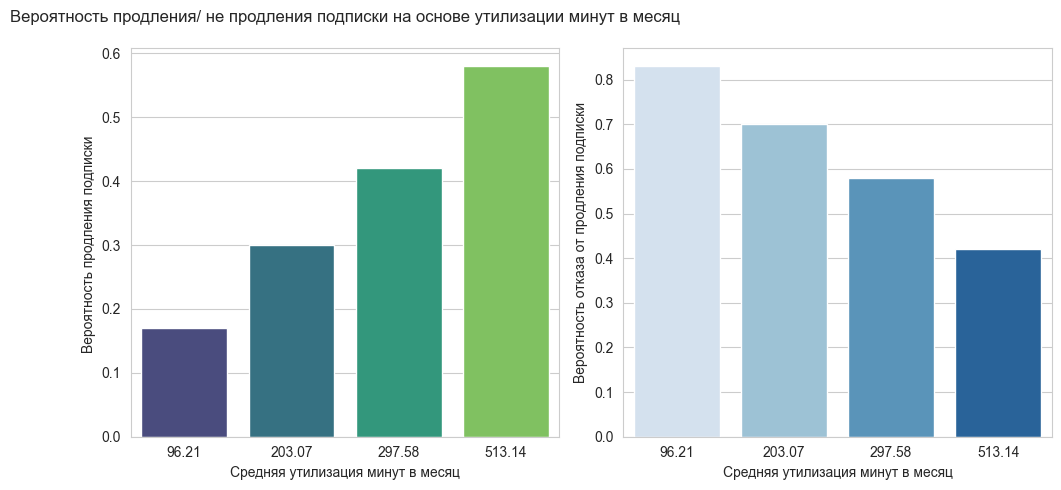

,duration_quartiles,duration,subscriptions,renewed,unrenewed,probability of subscribing,probability of not subscribing
0,30.00 - 154.00,96.21,2378,400,1978,0.17,0.83
1,154.11 - 250.00,203.07,2523,759,1764,0.30,0.70
2,250.17 - 351.33,297.58,2541,1066,1475,0.42,0.58
3,351.40 - 3007,513.14,2546,1481,1065,0.58,0.42


In [581]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


sns.barplot(data=merged_agg_months, x='duration', y='probability of subscribing', palette="viridis", ax=axs[0])
axs[0].set_title('Вероятность продления/ не продления подписки на основе утилизации минут в месяц\n')
axs[0].set_ylabel('Вероятность продления подписки ')
axs[0].set_xlabel('Cредняя утилизация минут в месяц')

sns.barplot(data=merged_agg_months, x='duration', y='probability of not subscribing', palette="Blues", ax=axs[1])
axs[1].set_ylabel('Вероятность отказа от продления подписки')
axs[1].set_xlabel('Cредняя утилизация минут в месяц')

# округляем и поворачиваем значения на оси X
xticklabels = axs[0].get_xticklabels()
xticklabels = [round(float(label.get_text()), 2) for label in xticklabels]
axs[0].set_xticklabels(xticklabels)#, rotation=90)

xticklabels = axs[1].get_xticklabels()
xticklabels = [round(float(label.get_text()), 2) for label in xticklabels]
axs[1].set_xticklabels(xticklabels)#, rotation=45)

plt.tight_layout()
plt.show()


merged_agg_months.reset_index().head()

#### Расчет вероятности продления на основе утилизации минут в неделю

In [585]:
# Утилизация по неделям общая
utilization_week = lessons.groupby([pd.Grouper(key='date_lessons', freq='W'), 'email']).agg({'duration':'sum'})

# Теперь чтобы посчитать утилизацию (мин в неделю), необходимо найти среднее количество минут, потраченных каждым клиентом в неделю
mean_utilization_week = utilization_week.groupby('email')['duration'].mean().reset_index()

# Определю квартили для средних утилизаций клиентов
mean_utilization_week = utilization_week.sort_values('duration', ascending = True)

# Разделяем ряд duration на квартили
mean_utilization_week['duration_quartiles'] = pd.qcut(mean_utilization_week['duration'], q=4, labels=['29.00 - 60.00', '61.00 - 94.00',
                                                                                                      '95.00 - 142.00', '143.00 - 1610'])

# Объединение таблиц
merged = pd.merge(mean_utilization_week, pay, on='email')

# Здесь считаем среднее время урока , общее число подписок , продление и не продление подписки по квартилям средней продолжительности занятия в неделю
merged_agg_week = merged.groupby('duration_quartiles').agg({'duration': 'mean', 'Транзакций': 'count'})\
                                                        .rename(columns={'Транзакций':'subscriptions'})

merged_agg_week['renewed'] = merged.query('Транзакций >= 2').groupby('duration_quartiles').agg({'email':'count'})
merged_agg_week['unrenewed'] = merged.query('Транзакций <= 1').groupby('duration_quartiles').agg({'email':'count'})
merged_agg_week['probability of subscribing'] = merged_agg_week['renewed'] / merged_agg_week['subscriptions']
merged_agg_week['probability of not subscribing'] = merged_agg_week['unrenewed'] / merged_agg_week['subscriptions']

merged_agg_week.reset_index().head()

,duration_quartiles,duration,subscriptions,renewed,unrenewed,probability of subscribing,probability of not subscribing
0,29.00 - 60.00,46.86,35423,18655,16768,0.53,0.47
1,61.00 - 94.00,81.05,20767,11522,9245,0.55,0.45
2,95.00 - 142.00,116.65,28314,17166,11148,0.61,0.39
3,143.00 - 1610,223.76,28117,19356,8761,0.69,0.31


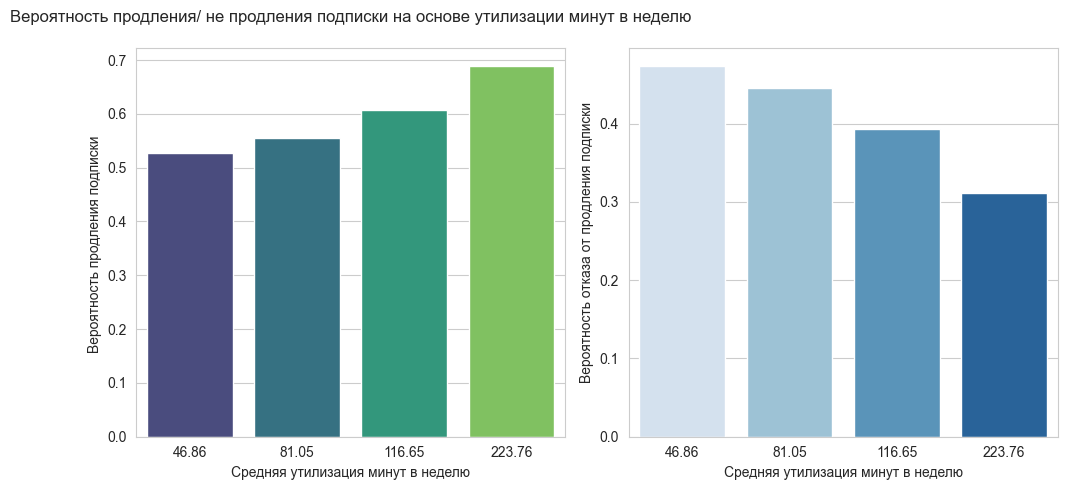

,duration,subscriptions,renewed,unrenewed,probability of subscribing,probability of not subscribing
duration_quartiles,,,,,,
29.00 - 60.00,46.86,35423,18655,16768,0.53,0.47
61.00 - 94.00,81.05,20767,11522,9245,0.55,0.45
95.00 - 142.00,116.65,28314,17166,11148,0.61,0.39
143.00 - 1610,223.76,28117,19356,8761,0.69,0.31


In [586]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


sns.barplot(data=merged_agg_week, x='duration', y='probability of subscribing', palette="viridis", ax=axs[0])
axs[0].set_title('Вероятность продления/ не продления подписки на основе утилизации минут в неделю\n')
axs[0].set_ylabel('Вероятность продления подписки ')
axs[0].set_xlabel('Cредняя утилизация минут в неделю')

sns.barplot(data=merged_agg_week, x='duration', y='probability of not subscribing', palette="Blues", ax=axs[1])
axs[1].set_ylabel('Вероятность отказа от продления подписки')
axs[1].set_xlabel('Cредняя утилизация минут в неделю')

# округляем и поворачиваем значения на оси X
xticklabels = axs[0].get_xticklabels()
xticklabels = [round(float(label.get_text()), 2) for label in xticklabels]
axs[0].set_xticklabels(xticklabels)#, rotation=90)

xticklabels = axs[1].get_xticklabels()
xticklabels = [round(float(label.get_text()), 2) for label in xticklabels]
axs[1].set_xticklabels(xticklabels)#, rotation=45)

plt.tight_layout()
plt.show()


merged_agg_week.head()

#### Расчет вероятности продления на основе минут в день

In [590]:
# Расчет количества минут, потраченных каждым клиентом в каждый день
utilization = lessons.groupby(['date_lessons', 'email'])['duration'].sum().reset_index()

# Теперь чтобы посчитать утилизацию (мин в день), необходимо найти среднее количество минут, потраченных каждым клиентом в каждый день
mean_utilization = utilization.groupby('email')['duration'].mean().reset_index()

# Определю квартили для средних утилизаций клиентов
mean_utilization = mean_utilization.sort_values('duration', ascending = True)

# Разделяем ряд duration на квартили
mean_utilization['duration_quartiles'] = pd.qcut(mean_utilization['duration'], q=4, labels=['29.95 - 41.62', '41.62 - 47.23',
                                                                                            '47.23 - 54.68', '54.70 - 128.56'])
# Объединение таблиц
merged = pd.merge(mean_utilization, pay, on='email')

# Здесь считаем среднее время урока , общее число подписок , продление и не продление подписки по квартилям средней продолжительности занятия в день
merged_agg = merged.groupby('duration_quartiles').agg({'duration': 'mean', 'Транзакций': 'count'})\
                                                 .rename(columns={'Транзакций':'subscriptions'})

merged_agg['renewed'] = merged.query('Транзакций >= 2').groupby('duration_quartiles').agg({'email':'count'})
merged_agg['unrenewed'] = merged.query('Транзакций <= 1').groupby('duration_quartiles').agg({'email':'count'})
merged_agg['probability of subscribing'] = merged_agg['renewed'] / merged_agg['subscriptions']
merged_agg['probability of not subscribing'] = merged_agg['unrenewed'] / merged_agg['subscriptions']

merged_agg.head()

,duration,subscriptions,renewed,unrenewed,probability of subscribing,probability of not subscribing
duration_quartiles,,,,,,
29.95 - 41.62,36.33,2505,656,1849,0.26,0.74
41.62 - 47.23,44.62,2542,915,1627,0.36,0.64
47.23 - 54.68,50.82,2488,1094,1394,0.44,0.56
54.70 - 128.56,61.10,2453,1041,1412,0.42,0.58


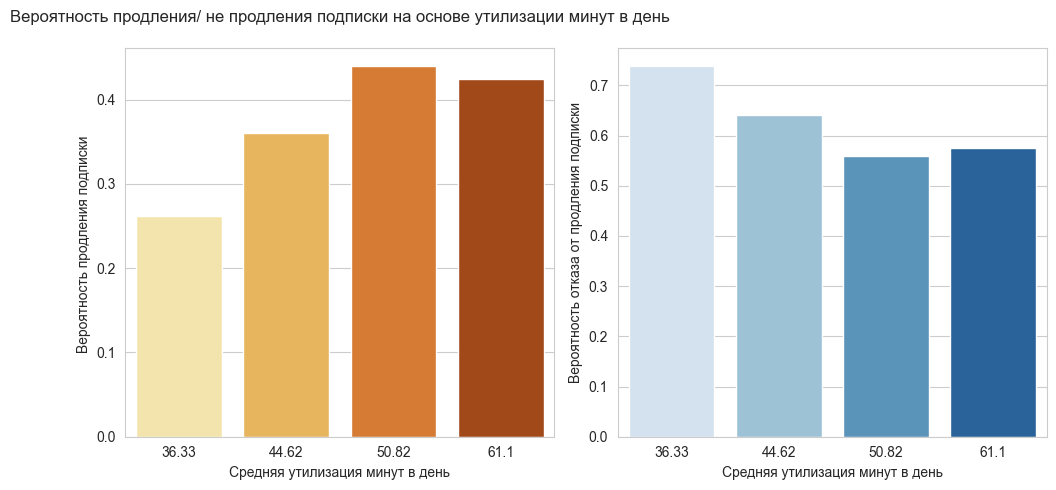

,duration,subscriptions,renewed,unrenewed,probability of subscribing,probability of not subscribing
duration_quartiles,,,,,,
29.95 - 41.62,36.33,2505,656,1849,0.26,0.74
41.62 - 47.23,44.62,2542,915,1627,0.36,0.64
47.23 - 54.68,50.82,2488,1094,1394,0.44,0.56
54.70 - 128.56,61.10,2453,1041,1412,0.42,0.58


In [591]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


sns.barplot(data=merged_agg, x='duration', y='probability of subscribing', palette="YlOrBr", ax=axs[0])
axs[0].set_title('Вероятность продления/ не продления подписки на основе утилизации минут в день\n')
axs[0].set_ylabel('Вероятность продления подписки ')
axs[0].set_xlabel('Cредняя утилизация минут в день')

sns.barplot(data=merged_agg, x='duration', y='probability of not subscribing', palette="Blues", ax=axs[1])
axs[1].set_ylabel('Вероятность отказа от продления подписки')
axs[1].set_xlabel('Cредняя утилизация минут в день')

# округляем и поворачиваем значения на оси X
xticklabels = axs[0].get_xticklabels()
xticklabels = [round(float(label.get_text()), 2) for label in xticklabels]
axs[0].set_xticklabels(xticklabels)#, rotation=90)

xticklabels = axs[1].get_xticklabels()
xticklabels = [round(float(label.get_text()), 2) for label in xticklabels]
axs[1].set_xticklabels(xticklabels)#, rotation=45)

plt.tight_layout()
plt.show()


merged_agg.head()